A brief overview of the fundemntal frequency (F0) estimators we studied and implemented over the course of the directed study

In [10]:
import sys
import contextlib
import wave
import array as ar
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences

from IPython.display import Audio

sys.path.append('.')
from pitch_determination import f0_estimator

In [11]:
sample_rate = 44100

# Piano key frequencies

notenames = ['A0', 'Bb0', 'B0', 'C1', 'C#1', 'D1', 'Eb1', 'E1', 'F1', 'F#1',
       'G1', 'Ab1', 'A1', 'Bb1', 'B1', 'C2', 'C#2', 'D2', 'Eb2', 'E2',
       'F2', 'F#2', 'G2', 'Ab2', 'A2', 'Bb2', 'B2', 'C3', 'C#3', 'D3',
       'Eb3', 'E3', 'F3', 'F#3', 'G3', 'Ab3', 'A3', 'Bb3', 'B3', 'C4',
       'C#4', 'D4', 'Eb4', 'E4', 'F4', 'F#4', 'G4', 'Ab4', 'A4', 'Bb4',
       'B4', 'C5', 'C#5', 'D5', 'Eb5', 'E5', 'F5', 'F#5', 'G5', 'Ab5',
       'A5', 'Bb5', 'B5', 'C6', 'C#6', 'D6', 'Eb6', 'E6', 'F6', 'F#6',
       'G6', 'Ab6', 'A6', 'Bb6', 'B6', 'C7', 'C#7', 'D7', 'Eb7', 'E7',
       'F7', 'F#7', 'G7', 'Ab7', 'A7', 'Bb7', 'B7', 'C8', 'R']

# Create chromatic scale, e.g., as on the piano, as a dictionary    

Freqs = {} 

f = 27.5

for name in notenames:
    Freqs[name] = f
    f *= 2**(1/12)

In [12]:
# I/O for Wave files

# Read a mono wave file from a local file and return the entire file as a 1-D numpy array

def readWaveFile(infile,withParams=False,asNumpy=True):
    with contextlib.closing(wave.open(infile)) as f:
        params = f.getparams()
        frames = f.readframes(params[3])
        if(params[0] != 1):
            print("Warning in reading file: must be a mono file!")
        if(params[1] != 2):
            print("Warning in reading file: must be 16-bit sample type!")
        if(params[2] != 44100):
            print("Warning in reading file: must be 44100 sample rate!")
    if asNumpy:
        X = ar.array('h', frames)
        X = np.array(X,dtype='int16')
    else:  
        X = array.array('h', frames)
    if withParams:
        return X,params
    else:
        return X

In [13]:
signal = readWaveFile('single_note_samples/trumpet-C4.wav')
actual_f0 = Freqs['C4']
print("Freq of signal:",actual_f0)
Audio(signal, rate=sample_rate)

Freq of signal: 261.62556530059896


# Autocorrelation

Straight forward autocorrelation.

## Autocorrelate against lagged window

We start the same way we'll start for all of these estimators: grab a slice from the signal of the specified window_size.

With autocorrelation, we increment the position of the window by one sample repeatedly and calculate the dot product of the contents of the window and the original lagged slice. These dot products are the correlation of the window and the original window slice, i.e. correlating the signal with itself at different slices.

## Analyze lagged correlations

When the windows are similar the dot product explodes. Periodic signals with multiple harmonics have repetitive segments of varying periods, with the segment of the largest period being that of the lowest frequency harmonic. This is the f0 we try to pinpoint.

The dot product will explod the most when the largest portion of the window matches. It follows that when the macro-period created by the f0 appears again, it will cause the dot product to be the largest.

## Find appropriate lag

We can use the smaple rate along with the lag value for when the dot product is the largest to get the f0 guess in Hz. But, we need the first lag that causes the large dot product, as the window will most often capture multiple instances of the f0 period. 

Ideally we could just take a global max of all the correlations. However, we need to do some peak picking and thresholding to avoid picking a peak that is too small created by a higher harmonic (creating an octave error) and to avoid picking a peak that was created by a repetition of the f0 period that happens to create a slightly larger correlation. Peak picking is done using the scipy library. Thresholding is done relatively by first normalizing the correlations by the max correlation across all the lags then applying the threshold to the search for the first peak.

With the peak-picking and threshold tuned and in place, we can just take the first valid peak's lag and divide the sample rate by that lag to get the f0 estimation.

### Interpolation

In basically all of these we perform an interpolation step to achieve a more accurate f0 estimation. Here we use parabolic interplation to get a fractional lag value that is closer to where the real maximum correlation would reside, as our lags are in terms of discrete samples.

In [14]:
estimated_f0 = f0_estimator.autocorrelation(signal, sample_rate, start=len(signal)//2, window_size=4410)
print("F0 estimation:\t",estimated_f0)
print("Error:\t\t",actual_f0-estimated_f0)

F0 estimation:	 261.34097587373094
Error:		 0.284589426868024


# YIN F0 Estimation

http://audition.ens.fr/adc/pdf/2002_JASA_YIN.pdf

YIN is based on the concepts from autocorrelation, but includes some extra steps and optimizations to get a noticiably better f0 estimation

## Normalized difference function

Instead of taking dot products for all the lagged windows, we take the squared difference of the slices scaled by the difference up to that lag.

- ### Difference function

The base of the normalized difference function is really just a shift from take the dot products to getting the squared difference in order to calculate the correlation for that lag. Lower is more similar here.

- ### Normalization

The normalization step tries to avoid octave errors by dividing the value at each lag in the old difference funciton by the average of the values of all shorter lags.

- ### Starting lag

The normalized difference function includes a conditoinal that for the 0 lag value, we set 1. This helps to avoid trivial errors and further help in avoid ocatve errors.

## Thresholding

The YIN algorithm incorporates a threshold basically in the same way that we did for autocorrelation, but inverted since we are going for minimums instead of maximums. Because we are guaranteed values in the magnitude close to 0 (otherwise the signal is not very periodic at all, which would kind of remove the premise for an estimator like this), we do not need to normalize and define a relative value to incorporate a consistent threshold.

## Best local estimate

Up to now we have not fully understood this final step in the YIN algorithm, so it is unimplemented.

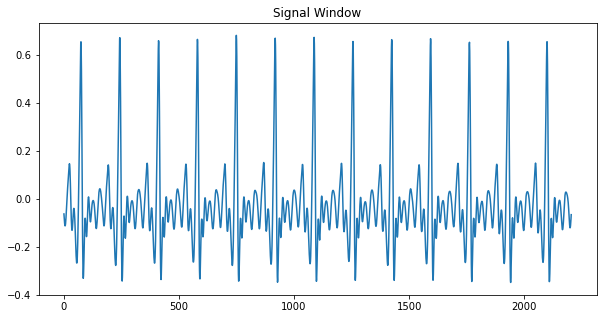

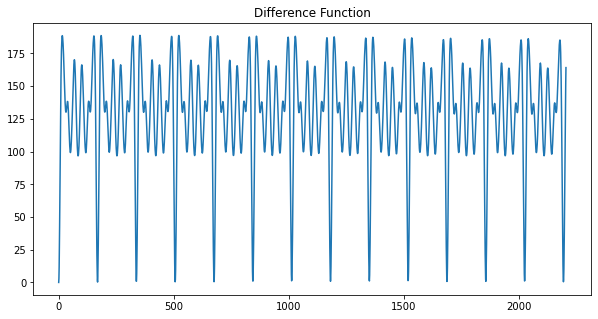

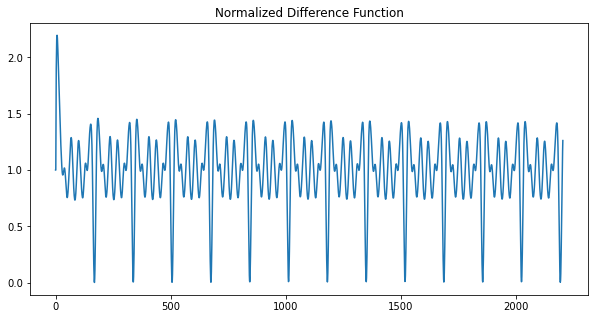

F0 estimation:	 261.3280036590339
Error:		 0.2975616415650393


In [15]:
estimated_f0 = f0_estimator.yin(signal, sample_rate, t=len(signal)//2, interpolate=True, display=True)
print("F0 estimation:\t",estimated_f0)
print("Error:\t\t",actual_f0-estimated_f0)

# Cepstrum Method

Nice blog post about this method: http://flothesof.github.io/cepstrum-pitch-tracking.html#What-is-a-cepstrum?

The cepstrum is the log of the of frequency spectrum. While the domain of the spectrum is the frequency, the domain of the cepstrum is quefrency. It's almost like the output of the cepstrum at a given quefrency is the rate at which that frequency's appears in the in the signal. The first significant peak in the cepstrum gives us the quefrency of our first repeating period, created by the f0.

We generate the quefrency axes by using differentials from our generated spectra. These are done nicely for us by numpy.

Once we have pinpointed the right quefrency, we convert it directly to Hz by taking its inverse, thanks to the pre-calulated domains.

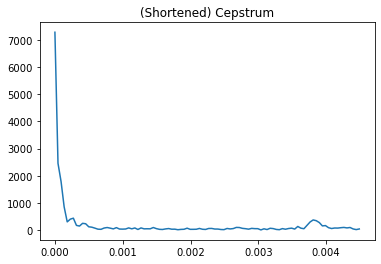

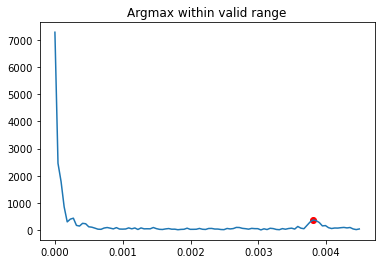

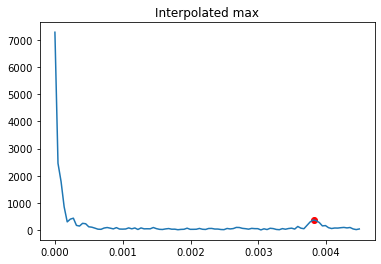

F0 estimation:	 261.8881279044268
Error:		 -0.2625626038278597


In [16]:
estimated_f0 = f0_estimator.cepstrum(signal, sample_rate, start=len(signal)//2, display=True)
print("F0 estimation:\t",estimated_f0)
print("Error:\t\t",actual_f0-estimated_f0)

# Estimation using Landmark Points

https://www.jstor.org/stable/3680825?seq=1

This method uses a computer graphics concept to find matching subsections of the waveform itself. With matches found we can calculate periodicity, which can be used to estimate the f0.

## Segments and subsegments

Segments in a wave are deliminated by positive-going zero-crossings. These are calculated as succinctly as possible using numpy.

Segments are compared to get their similarites and find periodicity. In order to caclulate similarity values, we divide segments into subsegments. Subsegments are 8 equal divisions of a segment. The boundaries at each of these subsegemnets will be used as landmarks.

## Landmarks

The features of each segment are defines as the first and last three subsegment boundaries for each segment.

## Similarity

Now that each segment has their 6 landmarks, we calculate the similarity between two segments using these landmarks (the function is described in the paper). We have ceratin threshold parameters for detecting that a segment is similar enough for consideration in the estimation.

## Estimation

We start with the largest segment in our window. We then compare it to every other segment in the window (skipping itself, of course). When we find a segment that satisfies our similarity and length thresholds, we do a calculation that incorporates their disatnce to estimate the size of the largest period in the signal which can be used to caluclate the f0!

F0 estimation:	 262.5
Error:		 -0.8744346994010357


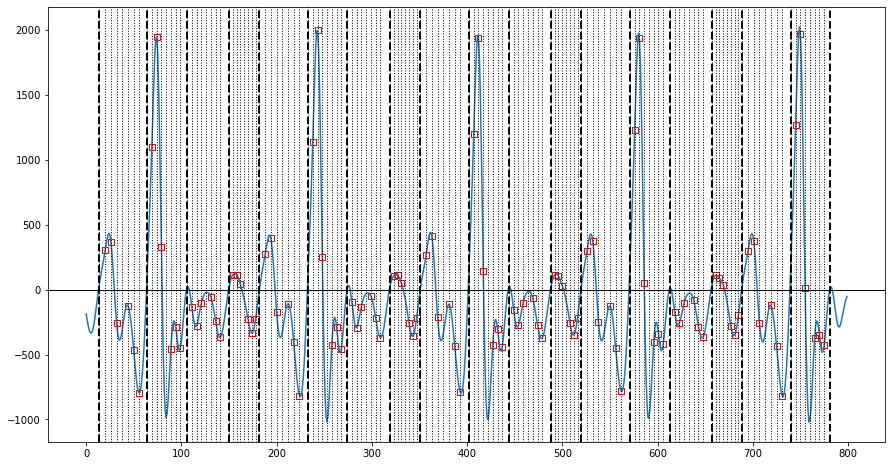

In [17]:
estimated_f0 = f0_estimator.landmark_points(signal, sample_rate, start=len(signal)//2, display=True)
print("F0 estimation:\t",estimated_f0)
print("Error:\t\t",actual_f0-estimated_f0)